# Similarity / Distance between Devices

In [24]:
from aux import *
import pandas as pd
from thefuzz import fuzz
import numpy as np
import json
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
plt.style.use('default')

## Devices SDF definitions

### Adapt SDF definition data for analysis

In [25]:
# Load SDF files to compare
sdf_manager = SDFManager(path='../iot/sdf/')
sdfs = sdf_manager.get_all_sdfs()

In [26]:
# Turn the SDF files into dataframes - Avoid redundant data
sdfs_trans = {}
columns = ['thing','thing_desc','obj','obj_desc','prop','prop_desc','prop_type','prop_unit']
rows = []
for name, sdf in sdfs.items() :
    if name == 'Auxiliary':
        continue
    for sdfThing, thing_dic in sdf['sdfThing'].items():
        thing_desc = thing_dic['description']
        for sdfObject, object_dic in thing_dic['sdfObject'].items():
            object_desc = object_dic['description']
            for sdfProperty, prop_dic in object_dic['sdfProperty'].items():
                if sdfProperty == 'uuid': continue
                prop_desc = prop_dic['description']
                prop_type = prop_dic['type']
                prop_unit = prop_dic['unit'] if 'unit' in prop_dic else None
                rows.append((sdfThing,thing_desc,sdfObject,object_desc,sdfProperty,prop_desc,prop_type,prop_unit))

sdfs_df = pd.DataFrame(columns=columns,data=rows)

In [27]:
# Air Quality SDF DATAFRAME
sdfs_df[sdfs_df.thing=='AirQualityModified'].iloc[:,2:].reset_index(drop=True)

,obj,obj_desc,prop,prop_desc,prop_type,prop_unit
0,temperature_humidity_sensor,Measures environmental temperature and humidity.,temperature,Temperature value,number,Cel
1,temperature_humidity_sensor,Measures environmental temperature and humidity.,humidity,Humidity value,number,%
2,air_quality_sensor,Measures air pollutants.,pm25,PM2.5 value,number,ug/m3
3,air_quality_sensor,Measures air pollutants.,pm10,PM10 value,number,ug/m3


## Devices data

### Load devices data

In [28]:
# Read devices data samples from JSON
with open('devices.json', 'r') as f: devices = json.load(f)

### Adapt devices data for analysis

In [29]:
# Build devices dataframe
rows = []
for dev_uuid, dev in devices.items() :
    # Dev row initialization
    row = {
        'uuid': dev_uuid,
        'dev' : dev['name'],
        'integ': dev['integrated'],
        'timestamp': dev['timestamp'],
        'period': dev['period']
    }
        
    # Create a row for each module attribute with a column for each value in the buffer
    for mod_uuid, mod in dev['modules'].items() :
        row['mod'] = mod['name']
        for prop_name, buffer in mod['attribs'].items() :
            row['attrib'] = prop_name
            for i, val in enumerate(buffer) :
                row[f'v{i+1}'] = val
            rows.append(row.copy())

# Build devices dataframe
devs_df = pd.DataFrame(rows)

In [30]:
# Drop columns without useful information
devs_df = devs_df.drop(columns=['integ','timestamp','period'])

## Similarity Analysis
Given an unknown device, determine the 5 closest devices according to SDF definition similarity, and then choose the closest device by including the buffered data. 

**Possible algorithm**

    Given an unknown device(thing) module(object) attribute(property), find 5 closest thing-object-property tuples according to SDF definition.

    Then, for each unknown module attribute, determine which attribute resembles the most to it of those in the 5 closest devices, and vote this device UUID as the candidate to be the closest.

    Finally, the device that has the most attribute votes is chosen as the closest device.

In [31]:
# Value columns names
n_vals = 20
val_cols = [f'v{i+1}' for i in range(n_vals)]

# Turn booleans into integers and cast all data to float
devs_df[val_cols] = devs_df[val_cols].replace('False',0).replace('True',1)
devs_df[val_cols] = devs_df[val_cols].astype(float)

In [32]:
# Air Quality Modified DEVICES DATAFRAME
devs_df[devs_df.dev=='AirQualityModified']

,uuid,dev,mod,attrib,v1,v2,v3,v4,v5,v6,...,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20
277,4c133df5-b9a0-48c9-81ad-5db2a5e81b3d,AirQualityModified,temperature_humidity_sensor,temperature,24.556996,25.653477,26.370232,24.509951,24.997302,24.786998,...,22.163592,21.415280,21.993675,21.384817,21.742847,21.811699,21.258213,22.016044,22.148902,21.361590
278,4c133df5-b9a0-48c9-81ad-5db2a5e81b3d,AirQualityModified,temperature_humidity_sensor,humidity,26.770624,27.606952,28.776131,28.819378,27.150436,27.090708,...,26.711143,26.468237,26.612122,27.064726,26.539593,27.267755,27.607051,27.598867,28.140130,28.297558
279,4c133df5-b9a0-48c9-81ad-5db2a5e81b3d,AirQualityModified,air_quality_sensor,pm25,13.240591,13.483619,13.534066,13.330977,13.131684,13.492882,...,14.979369,14.609200,14.477716,14.314967,14.542130,15.163335,14.562099,15.081989,15.318259,16.237336
280,4c133df5-b9a0-48c9-81ad-5db2a5e81b3d,AirQualityModified,air_quality_sensor,pm10,21.382047,21.670225,20.544093,19.826146,19.900233,19.481485,...,19.808047,19.510654,20.154744,20.390376,20.841990,21.330052,20.472432,20.727184,21.894446,21.220249


In [33]:
devs_df[devs_df.attrib == 'status'].describe()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.333333,0.266667,0.333333,0.333333,0.333333,0.333333,0.333333,0.266667,0.266667,0.200000,0.333333,0.333333,0.333333,0.333333,0.333333,0.266667,0.266667,0.266667,0.200000,0.333333
std,0.487950,0.457738,0.487950,0.487950,0.487950,0.487950,0.487950,0.457738,0.457738,0.414039,0.487950,0.487950,0.487950,0.487950,0.487950,0.457738,0.457738,0.457738,0.414039,0.487950
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000,0.500000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
# Unknown device
unknown_dev_name = 'AirQualityModified'

### Determine closest devices by SDF comparison

String similarity of the fields:
- Thing and its description
- Object and its description
- Property and its description

In [35]:
unknown_sdf = sdfs_df[sdfs_df.thing==unknown_dev_name]
known_sdfs = sdfs_df[sdfs_df.thing!=unknown_dev_name]

In [36]:
# Define distance functions
def calc_str_dist(descs, row):
    return fuzz.ratio(descs,row['thing_desc'] + ' ' + row['obj'] + ' ' + row['obj_desc'] + ' ' + row['prop'] + ' ' + row['prop_desc'])

# Compute closest devices by SDF
def get_closest_devs_by_sdf(unknown_sdf,known_sdfs,i) :
    unknown_row = unknown_sdf.iloc[i].copy()

    # Build joint description 
    descs = unknown_row['thing'] + ' ' + unknown_row['thing_desc'] + ' ' + unknown_row['obj'] + ' ' + unknown_row['obj_desc'] + ' ' + unknown_row['prop'] + ' ' + unknown_row['prop_desc']

    # Calc string distances
    knowns_alike = known_sdfs[known_sdfs.prop_type==unknown_row['prop_type']].copy()
    knowns_alike['str_dist'] = knowns_alike.apply(lambda x: calc_str_dist(descs,x), axis=1)
    closest_things = knowns_alike[['thing','obj','prop','str_dist']].sort_values(by='str_dist',ascending=False)

    # Give point based on closeness
    score = 5
    vote = {}
    for row in closest_things.itertuples() :
        candidate = row.thing+'/'+row.obj+'/'+row.prop
        if candidate not in vote :
            vote[candidate] = score
            score -= 1

        if score == 0 :
            break
        
    return vote

In [44]:
# Compute distance for each unknown module attribute
votes = (Parallel(n_jobs=12)(delayed(get_closest_devs_by_sdf)(unknown_sdf,known_sdfs,i) for i in range(unknown_sdf.shape[0])))
total_vote_sdf = {}
for vote in votes:
    for candidate, score in vote.items() :
        if candidate not in total_vote_sdf :
            total_vote_sdf[candidate] = score
        else :
            total_vote_sdf[candidate] += score

In [45]:
total_vote_sdf

{'AirQuality/temperature_sensor/temperature': 9,
 'AirQuality/humidity_sensor/humidity': 13,
 'AirQuality/pressure_sensor/pressure': 8,
 'AirQuality/air_quality_sensor/pm10': 13,
 'AirQuality/air_quality_sensor/pm1': 11,
 'AirQuality/air_quality_sensor/pm25': 6}

### Compare attributes time series

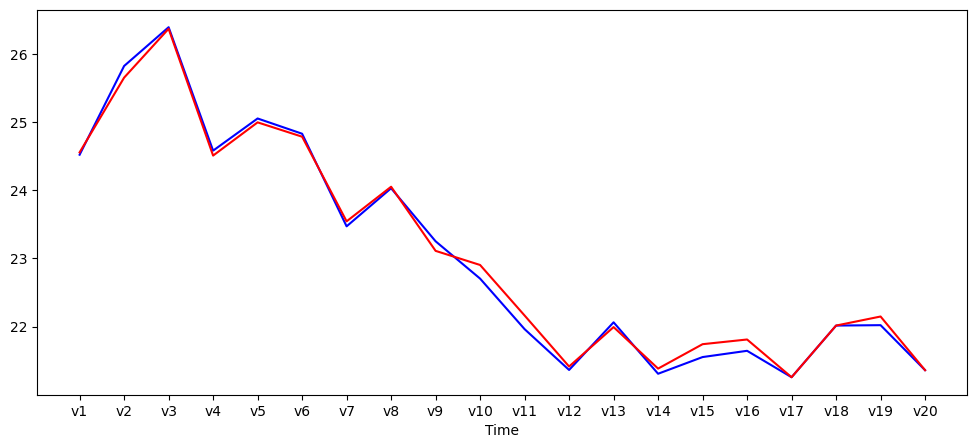

In [46]:
plt.figure(figsize=(12,5))
plt.xlabel('Time')

dev_uuid = "5362cb80-381d-4d21-87ba-af283640fa98"
mod_name, attrib_name = 'temperature_sensor', 'temperature'
buffer_data = devs_df[(devs_df['uuid']==dev_uuid)&(devs_df['mod']==mod_name)&(devs_df['attrib']==attrib_name)].iloc[0][val_cols]
ax1 = plt.plot(buffer_data, color='blue', label='AirQuality')

dev_uuid = devs_df[devs_df.dev=='AirQualityModified'].iloc[0].uuid
mod_name, attrib_name = 'temperature_humidity_sensor', 'temperature'
buffer_data = devs_df[(devs_df['uuid']==dev_uuid)&(devs_df['mod']==mod_name)&(devs_df['attrib']==attrib_name)].iloc[0][val_cols]
ax2 = plt.plot(buffer_data, color='red', label='AirQualityModified')

plt.show()

### Determine closest device UUID by buffered values comparison

Get the attribute with the closest values (euclidean distance) to each of the unknown device module attributes

In [40]:
unknown_uuid = '' # UUID of the unknown device
unknown_dev = devs_df[devs_df.dev==unknown_dev_name]
known_devs = devs_df[devs_df.dev!=unknown_dev_name]

In [41]:
# Compute closest devices by values comparison
def get_closest_devs_by_values(unknown_dev,known_devs,i) :
    unknown_row = unknown_dev.iloc[i].copy()

    # Calc string distances
    knowns_alike = known_devs.copy()
    knowns_alike['dist'] = ((knowns_alike[val_cols] - unknown_row[val_cols])**2).sum(axis=1)**0.5
    closest_things = knowns_alike[['uuid','dev','mod','attrib','dist']].sort_values(by='dist',ascending=True)

    # Give points based on closeness
    score = 5
    vote = {}
    for row in closest_things.itertuples() :
        candidate = row.uuid+'/'+row.dev+'/'+row.mod+'/'+row.attrib
        if candidate not in vote :
            vote[candidate] = score
            score -= 1

        if score == 0 :
            break
        
    return vote

In [42]:
# Compute distance for each unknown module attribute
votes = (Parallel(n_jobs=12)(delayed(get_closest_devs_by_values)(unknown_dev,known_devs,i) for i in range(unknown_dev.shape[0])))
total_vote_dev = {}
for vote in votes:
    for candidate in vote :
        if candidate not in total_vote_dev :
            total_vote_dev[candidate] = vote[candidate]
        else :
            total_vote_dev[candidate] += vote[candidate]

In [43]:
total_vote_dev

{'5362cb80-381d-4d21-87ba-af283640fa98/AirQuality/temperature_sensor/temperature': 6,
 '98247600-c4fe-4728-bda6-ed8fadf81af2/DrillingRobot/joint1/roll_orientation': 6,
 'c11c3f56-0f26-415f-a00d-3bb929f5ca20/AirQuality/air_quality_sensor/pm10': 4,
 '5362cb80-381d-4d21-87ba-af283640fa98/AirQuality/air_quality_sensor/pm10': 7,
 '5ce94c31-3004-431e-97b3-c8f779fb180d/MillingRobot/joint1/yaw_orientation': 3,
 '5362cb80-381d-4d21-87ba-af283640fa98/AirQuality/humidity_sensor/humidity': 5,
 '5ce94c31-3004-431e-97b3-c8f779fb180d/MillingRobot/joint1/pitch_orientation': 4,
 'fbeaa5f3-e532-4e02-8429-c77301f46470/ConveyorBelt/conveyor_belt/rotational_speed': 3,
 '5362cb80-381d-4d21-87ba-af283640fa98/AirQuality/air_quality_sensor/pm25': 5,
 '8a40d136-8401-41bd-9845-7dc8f28ea582/TagScanner/rfid_scanner/product_id': 4,
 '8a40d136-8401-41bd-9845-7dc8f28ea582/TagScanner/rfid_scanner/process_id': 3,
 'fbeaa5f3-e532-4e02-8429-c77301f46470/ConveyorBelt/conveyor_belt/weight': 2,
 '4525aa12-06fb-484f-be38-58a